In [3]:
# !pip install ipywidgets widgetsnbextension pandas-profiling
# !jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [37]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 437 kB/s eta 0:00:01


In [54]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

### Reading Data

In [2]:
%matplotlib inline
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [7]:
# !pip install openpyxl

     |████████████████████████████████| 242 kB 180 kB/s eta 0:00:01


In [3]:
df = pd.read_excel('../data/Prices.xlsx', sheet_name='Daily', skiprows=8, usecols='D:E', index_col='Name')
df.index

DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15'],
              dtype='datetime64[ns]', name='Name', length=11296, freq=None)

In [9]:
df.head()

,US dollar
Name,
1978-12-29,226.00
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15


In [5]:
df.index # already a datetime index

DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
               '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13',
               '2022-04-14', '2022-04-15'],
              dtype='datetime64[ns]', name='Name', length=11296, freq=None)

In [17]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11296 entries, 1978-12-29 to 2022-04-15
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   US dollar  11296 non-null  float64
dtypes: float64(1)
memory usage: 176.5 KB


In [18]:
df.describe()

,US dollar
count,11296.000000
mean,711.486215
std,491.268874
min,216.850000
25%,353.375000
50%,419.250000
75%,1192.087500
max,2067.150000


### Visualization and Analytics

             US dollar
Name                  
1978-12-31  226.000000
1979-01-31  227.215217
1979-02-28  245.670000
1979-03-31  242.047727
1979-04-30  238.664286


<AxesSubplot:xlabel='Name'>

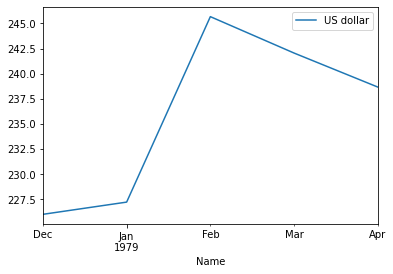

In [7]:
# Mean value at the end of month
print(df.resample(rule='M').mean().head())
df.resample(rule='M').mean().head().plot() # 1978 Dec - 1979 April

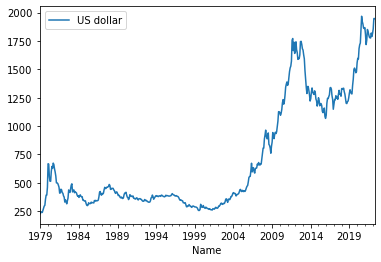

In [8]:
df.resample(rule='M').mean().plot(); # 1978 Dec-Curr

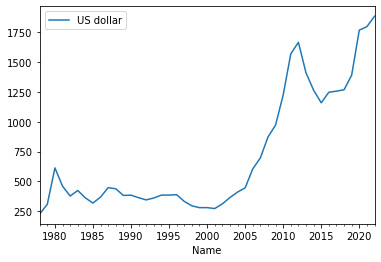

In [9]:
df.resample(rule='AS').mean().plot(); # year start resample, less noise

In [10]:
df.rolling(window=30).mean()[30:] # rolling average of every month

,US dollar
Name,
1979-02-09,230.735000
1979-02-12,231.343333
1979-02-13,231.803333
1979-02-14,232.538333
1979-02-15,233.358333
...,...
2022-04-11,1945.310000
2022-04-12,1946.605000
2022-04-13,1948.213333


<AxesSubplot:xlabel='Name'>

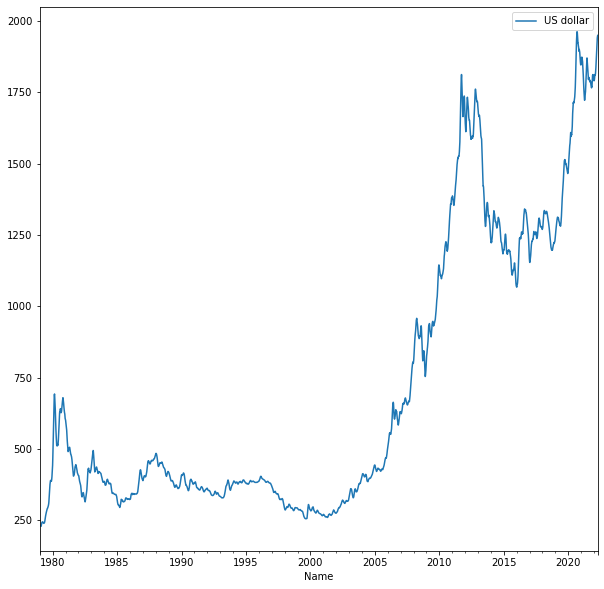

In [11]:
df.rolling(window=30).mean().plot(figsize=(10,10)) # rolling average of every month

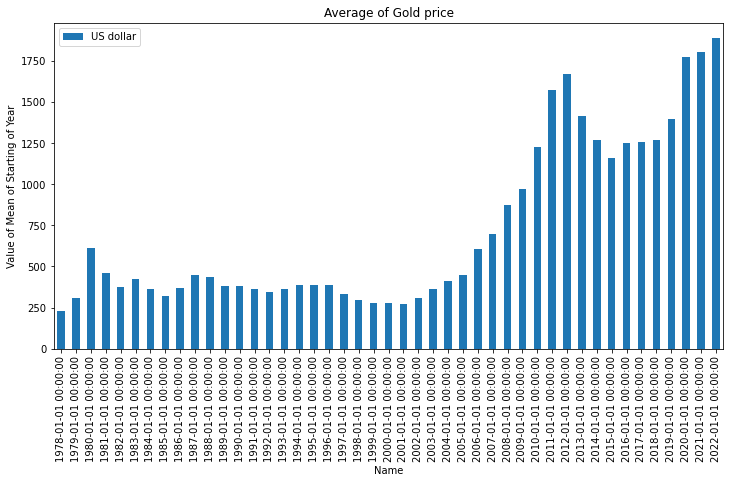

In [12]:
ax = df.resample(rule='AS').mean().plot.bar(figsize=(12,6))
ax.set(title='Average of Gold price', ylabel='Value of Mean of Starting of Year');

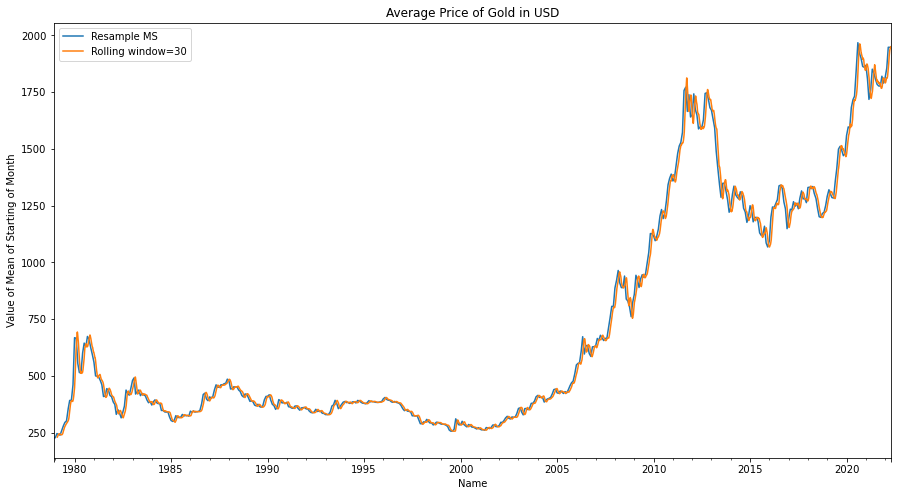

In [13]:
ax = df['US dollar'].resample(rule='M').mean().plot(figsize=(15,8), label='Resample MS')
ax.autoscale(tight=True)
df.rolling(window=30).mean()['US dollar'].plot(label='Rolling window=30')

ax.set(ylabel='Value of Mean of Starting of Month',title='Average Price of Gold in USD')
ax.legend()

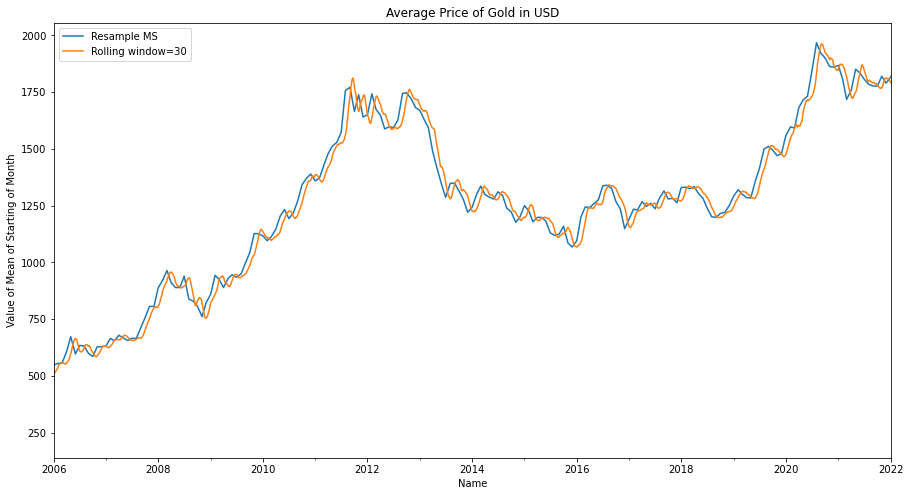

In [14]:
# rolling mean from 2006, till 2020 to check the spike and decrease.

ax = df['US dollar'].resample(rule='M').mean().plot(xlim=['2006-01-01','2022-01-01'], figsize=(15,8), label='Resample MS')
ax.autoscale(tight=True)
df.rolling(window=30).mean()['US dollar'].plot(xlim=['2006-01-01','2022-01-01'],label='Rolling window=30')

ax.set(ylabel='Value of Mean of Starting of Month',title='Average Price of Gold in USD')
ax.legend()

#### Dollar Price moving avg every 1 year vs every 5 year

<AxesSubplot:xlabel='ds'>

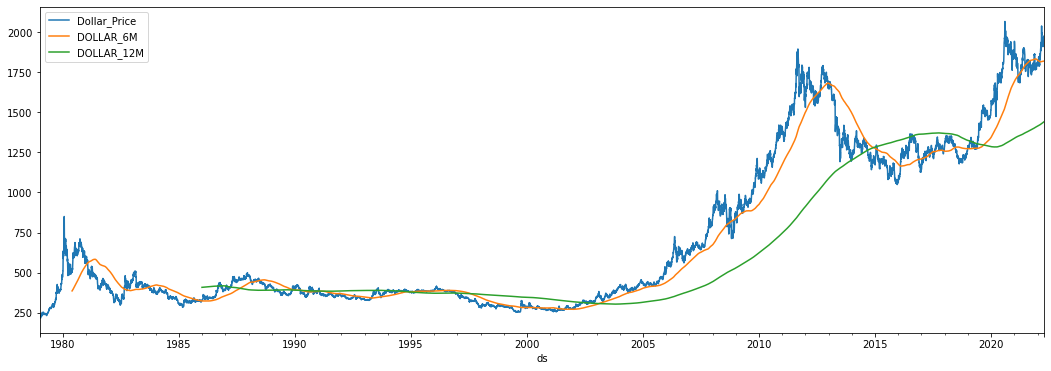

In [27]:
df['DOLLAR_6M'] = df['Dollar_Price'].rolling(window=365).mean()
df['DOLLAR_12M'] = df['Dollar_Price'].rolling(window=365*5+1).mean()
df[['Dollar_Price','DOLLAR_6M','DOLLAR_12M']].plot(figsize=(18,6))

In [30]:
del  df['DOLLAR_12M'],df['DOLLAR_6M']

# Models
* ARIMA
* FBProphet
* Bi-directional LSTM
* Pycaret

* ### FBProphet

In [15]:
# !pip install fbprophet

In [16]:
prophet_model = Prophet(interval_width=0.95)

In [6]:
# renaming for fbprophet
df.rename_axis('ds', inplace=True)
df.rename(columns={'US dollar':'y'}, inplace=True)
df.reset_index(inplace=True) 

df.head()

,ds,y
0,1978-12-29,226.00
1,1979-01-01,226.00
2,1979-01-02,226.80
3,1979-01-03,218.60
4,1979-01-04,223.15


In [18]:
prophet_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### predictions

In [19]:
future_dataset= prophet_model.make_future_dataframe(periods=15, freq='y') # 15 YEARS OF DATA

In [20]:
future_dataset.tail()

,ds
11306,2032-12-31
11307,2033-12-31
11308,2034-12-31
11309,2035-12-31
11310,2036-12-31


In [21]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1978-12-29,198.190717,37.649574,350.666259
1,1979-01-01,202.610300,34.265326,375.458218
2,1979-01-02,204.201136,35.816410,362.521922
3,1979-01-03,205.976840,42.288406,362.155616
4,1979-01-04,207.627541,52.584523,371.711477


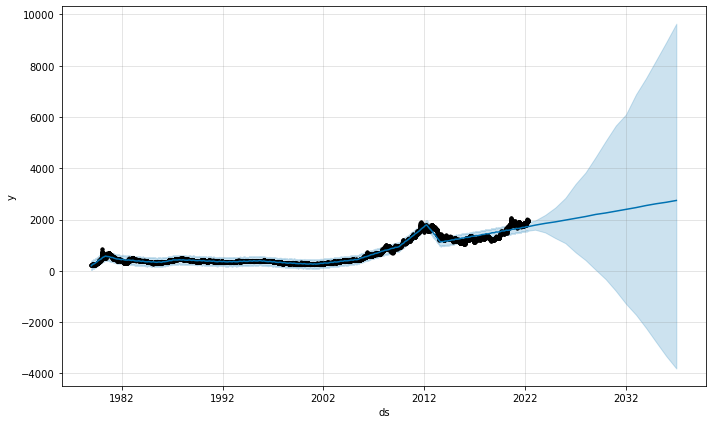

In [22]:
prophet_model.plot(pred);

In [23]:
date_pred='2030-12-12'

In [24]:
date = pd.DataFrame({'ds':pd.date_range(start=date_pred, end=date_pred)})

date.head()

,ds
0,2030-12-12


In [25]:
pred = prophet_model.predict(date)

In [26]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2030-12-12,2330.335897,-818.836881,5571.555966,-864.922215,5654.791374,-9.169629,-9.169629,-9.169629,-3.274349,-3.274349,-3.274349,-5.89528,-5.89528,-5.89528,0.0,0.0,0.0,2321.166269


#### saving

In [27]:
with open('../models/fbprophet.pckl', 'wb') as fout:
    pickle.dump(prophet_model, fout)

* ### ARIMA

In [40]:
# !pip install statsmodels==0.11.0 

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\hp\\anaconda3\\envs\\time_series\\lib\\site-packages\\~tatsmodels\\tsa\\innovations\\_arma_innovations.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.




  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.2
    Uninstalling statsmodels-0.13.2:
      Successfully uninstalled statsmodels-0.13.2


In [8]:
df.set_index('ds', inplace=True)
df.columns

Index(['y'], dtype='object')

In [9]:
df.rename(columns={'y':'Dollar_Price'}, inplace=True)

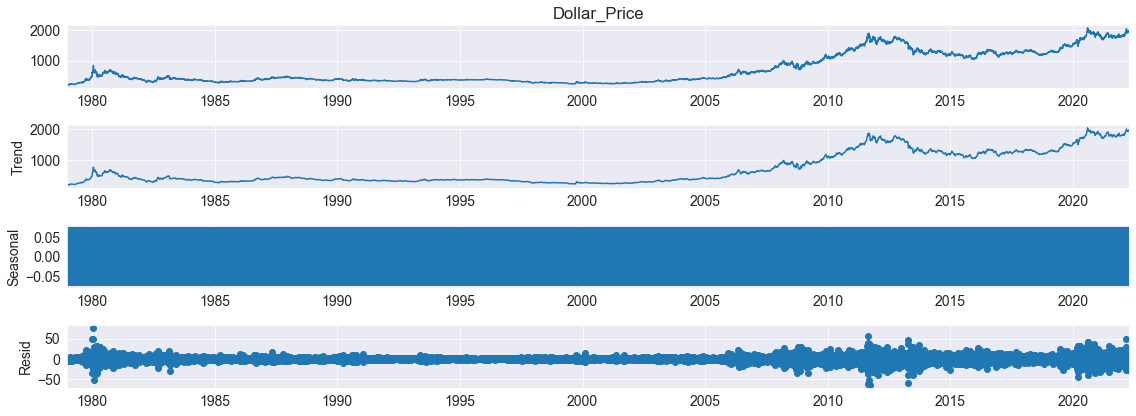

In [10]:
result_add = seasonal_decompose(df['Dollar_Price'],model = 'add')
result_add.plot(15, 6);

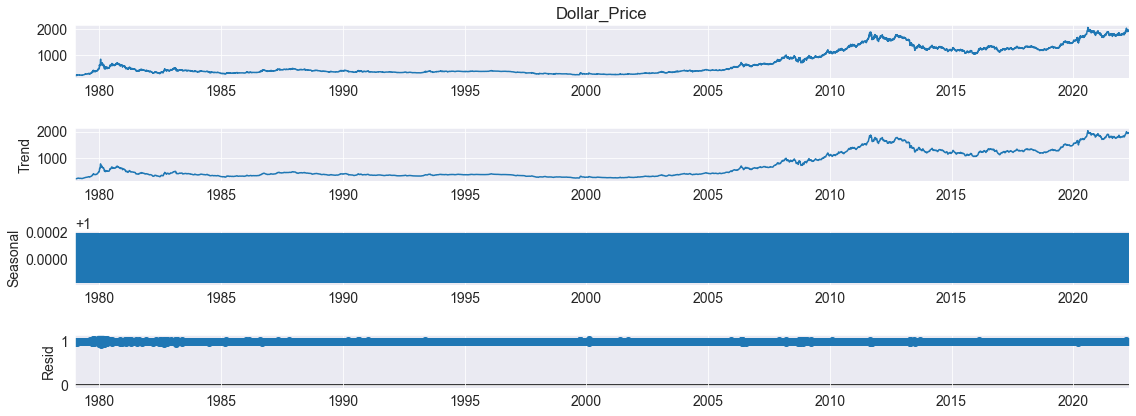

In [11]:
result_mul = seasonal_decompose(df['Dollar_Price'],model = 'mul')
result_mul.plot();

In [20]:
# !pip install statsmodels

     |████████████████████████████████| 9.8 MB 540 kB/s eta 0:00:01
     |████████████████████████████████| 233 kB 2.0 MB/s eta 0:00:01


In [4]:
#Check If Time Series Data is Stationary
#Data needs to be stationary before modeling. Run Dicky-Fuller test on the Open Price

data_diff = df.diff().dropna()
diff_adfuller_result = adfuller(data_diff['US dollar'])
print('Difference Method ADF Statistic: ', diff_adfuller_result[0])
print('Difference Method p-value: ', diff_adfuller_result[1])
# p value < 0.5

Difference Method ADF Statistic:  -17.624485415618746
Difference Method p-value:  3.8245670824612776e-30


In [5]:
# 2nd method
data_sqrt = np.sqrt(df).dropna()
sqrt_adfuller_result = adfuller(data_sqrt['US dollar'])
print('Square Root Method ADF Statistic: ', sqrt_adfuller_result[0])
print('Square Root Methodp-value: ', sqrt_adfuller_result[1])

# p value > 0.5

Square Root Method ADF Statistic:  0.09101430139858872
Square Root Methodp-value:  0.965442216821896


In [6]:
# Diff Twice Method
data_difftwice = df.diff().diff().dropna()
difftwice_adfuller_result = adfuller(data_difftwice['US dollar'])
print('Difference Method ADF Statistic: ', difftwice_adfuller_result[0])
print('Difference Method p-value: ', difftwice_adfuller_result[1])

Difference Method ADF Statistic:  -29.373023512567457
Difference Method p-value:  0.0


Conclusion

The Square Root methods didn't produce a p-value less than 0.05. So we should eliminate it. Both Differencing once and twice methods produced a p-value less than 0.05 but Differencing Twice produced a much more negative ADF Statistic. That's what we want, the more negative the better.

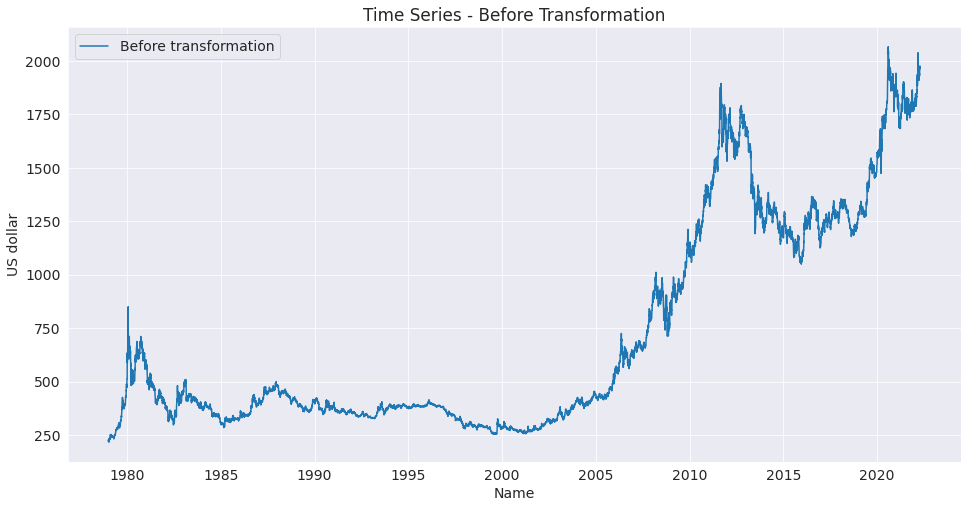

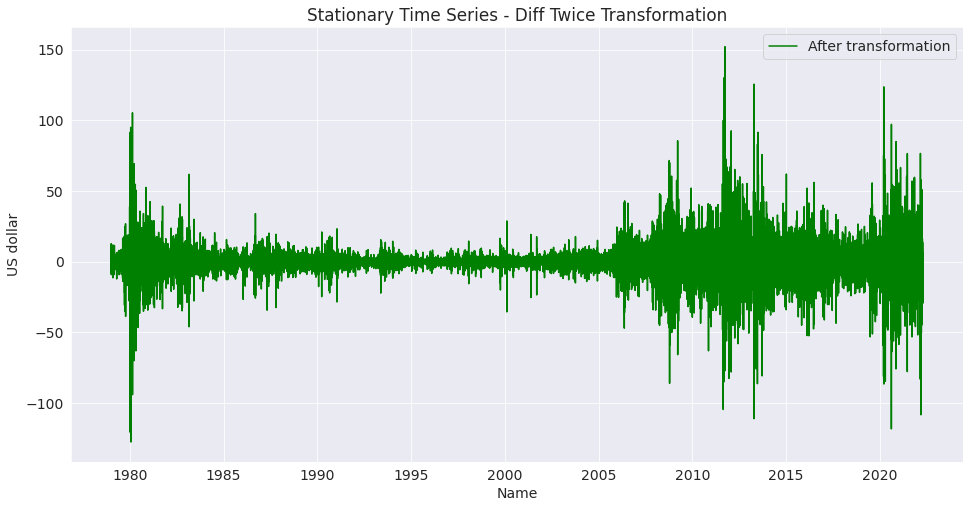

In [7]:
plt.figure(figsize=(16,8))
sns.lineplot(x=df.index, y='US dollar', data=df, linewidth=1.5, label='Before transformation').set_title('Time Series - Before Transformation')
plt.show()

# Plot the time series after transformation
plt.figure(figsize=(16,8))
sns.lineplot(x=data_difftwice.index, y='US dollar', data=data_difftwice, label='After transformation', color='green').set_title('Stationary Time Series - Diff Twice Transformation')
plt.show()

/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


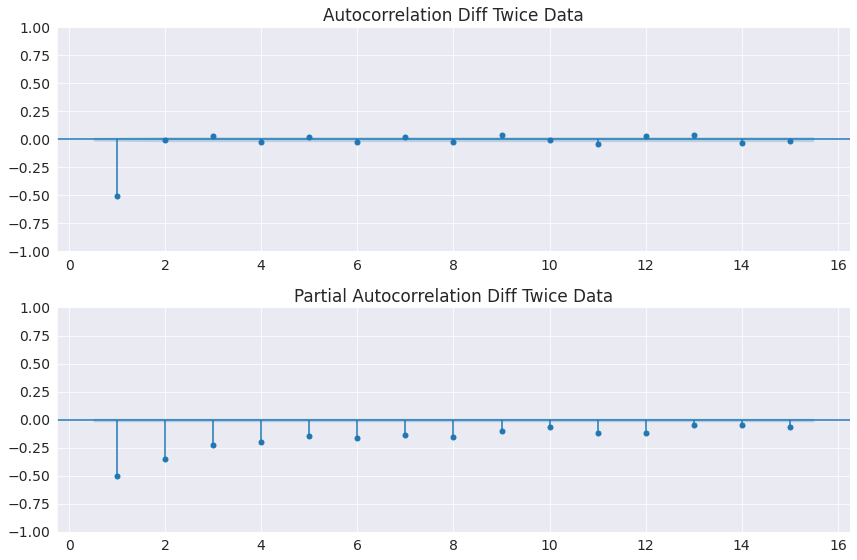

In [34]:
# Plot ACF and PACF with stationary data using data that was differenced twice

fig_difftwice, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of data_difftwice
plot_acf(data_difftwice['US dollar'], lags=15, zero=False, ax=ax1, title='Autocorrelation Diff Twice Data')

# Plot PACF of data_difftwice
plot_pacf(data_difftwice['US dollar'], lags=15, zero=False, ax=ax2, title='Partial Autocorrelation Diff Twice Data')
plt.tight_layout()
plt.show()

Initial Observation

ACF - Cuts off after lag 1

PACF - tails off

Initial conclusion: It may be a MA(1) model.

/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


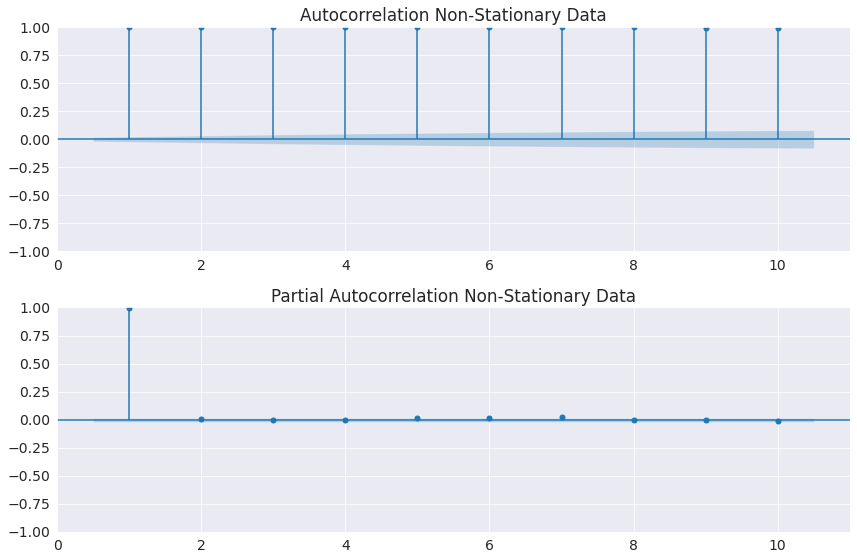

In [35]:
fig_data_gld, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of data_difftwice
plot_acf(df['US dollar'], lags=10, zero=False, ax=ax1, title='Autocorrelation Non-Stationary Data')

# Plot PACF of data_difftwice
plot_pacf(df['US dollar'], lags=10, zero=False, ax=ax2, title='Partial Autocorrelation Non-Stationary Data')
plt.tight_layout()
plt.show()

Conclusion

The ACF cuts off after lag 1 and the PACF tails off. This may indicate that a Moving Average Model with an order of 1 MA(1) might be the best. However, there are limitations to the ACF and PACF method. We are making the judgement based on how the ACF and PACF graphs look. Sometimes it may not be as clear to make a conclusion.

Next, let's use a different method to pick the optimal model order - the AIC and BIC.



Akaike Information Criterion (AIC)

Lower AIC indicates a better model
* AIC is ideal for simple models with lower order
* Bayesian Information Criterion (BIC)

Lower BIC indicates a better model
* BIC penalizes complex models
* Most of the times, AIC and BIC will select the same model order. However, when they don't, we have to make a choice which to pick:

* AIC - better at choosing predictive models (use this if that’s our goal)
* BIC - better at choosing good explanatory model (use this if that’s our goal)

In [7]:
order_aic_bic = []

# Loop over AR order
for p in range(3):
    # Loop over MA order
    for q in range(3):
        try:
            # Fit model
            sarima_model = SARIMAX(data_difftwice['US dollar'], order=(p,0,q))
            results = sarima_model.fit()
            # Store the model order and the AIC/BIC values in order_aic_bic list
            order_aic_bic.append((p, q, results.aic, results.bic))
            #print(p, q, results.aic, results.bic)
        except Exception as E:
            # Print AIC and BIC as None when fails
            print(p, q, None, None)

/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05200D+00    |proj g|=  5.16032D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.160D-08   4.052D+00
  F =   4.0519973182017903     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76785D+00    |proj g|=  7.29352D-02


 This problem is unconstrained.



At iterate    5    f=  3.70255D+00    |proj g|=  2.27095D-03

At iterate   10    f=  3.69750D+00    |proj g|=  1.03345D-04

At iterate   15    f=  3.69702D+00    |proj g|=  8.90017D-05

At iterate   20    f=  3.69699D+00    |proj g|=  5.04818D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     20     22      1     0     0   5.048D-06   3.697D+00
  F =   3.6969902372949504     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74136D+00    |proj g|=  3.74123D-02

At iterate    5    f=  3.70496D+00    |proj g|=  3.77882D-03

At iterate   10    f=  3.69764D+00    |proj g|=  7.66453D-04

At iterate   15    f=  3.69692D+00    |proj g|=  7.15494D-04

At iterate   20    f=  3.69683D+00    |proj g|=  2.71609D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   1.943D-06   3.697D+00
  F =   3.6968280478778399     

CONVERG

/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90534D+00    |proj g|=  4.12078D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   2.276D-05   3.905D+00
  F =   3.9053406969657938     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77068D+00    |proj g|=  1.09253D-01


 This problem is unconstrained.



At iterate    5    f=  3.70720D+00    |proj g|=  1.04657D-02

At iterate   10    f=  3.69831D+00    |proj g|=  5.83371D-03

At iterate   15    f=  3.69697D+00    |proj g|=  1.57352D-03

At iterate   20    f=  3.69683D+00    |proj g|=  1.23531D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   1.381D-05   3.697D+00
  F =   3.6968312539583557     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74412D+00    |proj g|=  5.62968D-02

At iterate    5    f=  3.69784D+00    |proj g|=  1.42962D-03

At iterate   10    f=  3.69702D+00    |proj g|=  1.55697D-04

At iterate   15    f=  3.69699D+00    |proj g|=  8.70351D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   4.966D-06   3.697D+00
  F =   3.6969888725634497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84031D+00    |proj g|=  4.68926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   1.786D-05   3.840D+00
  F =   3.8403072510474985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77861D+00    |proj g|=  9.64836D-02


 This problem is unconstrained.



At iterate    5    f=  3.71698D+00    |proj g|=  5.52718D-02

At iterate   10    f=  3.70057D+00    |proj g|=  4.91208D-03

At iterate   15    f=  3.69726D+00    |proj g|=  1.44389D-03

At iterate   20    f=  3.69685D+00    |proj g|=  1.21614D-03

At iterate   25    f=  3.69679D+00    |proj g|=  4.31311D-05

At iterate   30    f=  3.69678D+00    |proj g|=  3.29092D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     34      1     0     0   3.291D-06   3.697D+00
  F =   3.6967847314616726     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74677D+00    |proj g|=  5.43988D-02

At iterate    5    f=  3.70065D+00    |proj g|=  3.36063D-02

At iterate   10    f=  3.69689D+00    |proj g|=  9.50969D-04

At iterate   15    f=  3.69685D+00    |proj g|=  1.11731D-03

At iterate   20    f=  3.69682D+00    |proj g|=  1.14148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.482D-04   3.697D+00
  F =   3.6968223188004754     

CONVERG

In [8]:
# Make a dataframe of model order using AIC/BIC scores
aic_bic_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])
print(aic_bic_df.sort_values('aic')) # sorted scores, 1,0,1 is minimum
print(aic_bic_df.sort_values('bic')) # 1,0,1 is miminuim

   p  q           aic           bic
2  0  2  83509.951945  83531.948026
4  1  1  83510.024364  83532.020445
7  2  1  83510.973514  83540.301622
1  0  1  83511.615480  83526.279534
8  2  2  83513.822537  83550.482672
5  1  2  83515.584653  83544.912761
6  2  0  86750.860187  86772.856267
3  1  0  88217.835663  88232.499717
0  0  0  91528.515424  91535.847450
   p  q           aic           bic
1  0  1  83511.615480  83526.279534
2  0  2  83509.951945  83531.948026
4  1  1  83510.024364  83532.020445
7  2  1  83510.973514  83540.301622
5  1  2  83515.584653  83544.912761
8  2  2  83513.822537  83550.482672
6  2  0  86750.860187  86772.856267
3  1  0  88217.835663  88232.499717
0  0  0  91528.515424  91535.847450


In [8]:
p,q,d = 0, 1, 2

sarima_model = SARIMAX(df['US dollar'], order=(p,d,q), trend='c')
results_sarima = sarima_model.fit()

/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76719D+00    |proj g|=  7.29223D-02

At iterate    5    f=  3.70760D+00    |proj g|=  2.73728D-02

At iterate   10    f=  3.69930D+00    |proj g|=  1.41453D-01

At iterate   15    f=  3.69680D+00    |proj g|=  3.02670D-03

At iterate   20    f=  3.69639D+00    |proj g|=  9.63909D-02

At iterate   25    f=  3.69628D+00    |proj g|=  2.12526D-01

At iterate   30    f=  3.69627D+00    |proj g|=  7.73370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

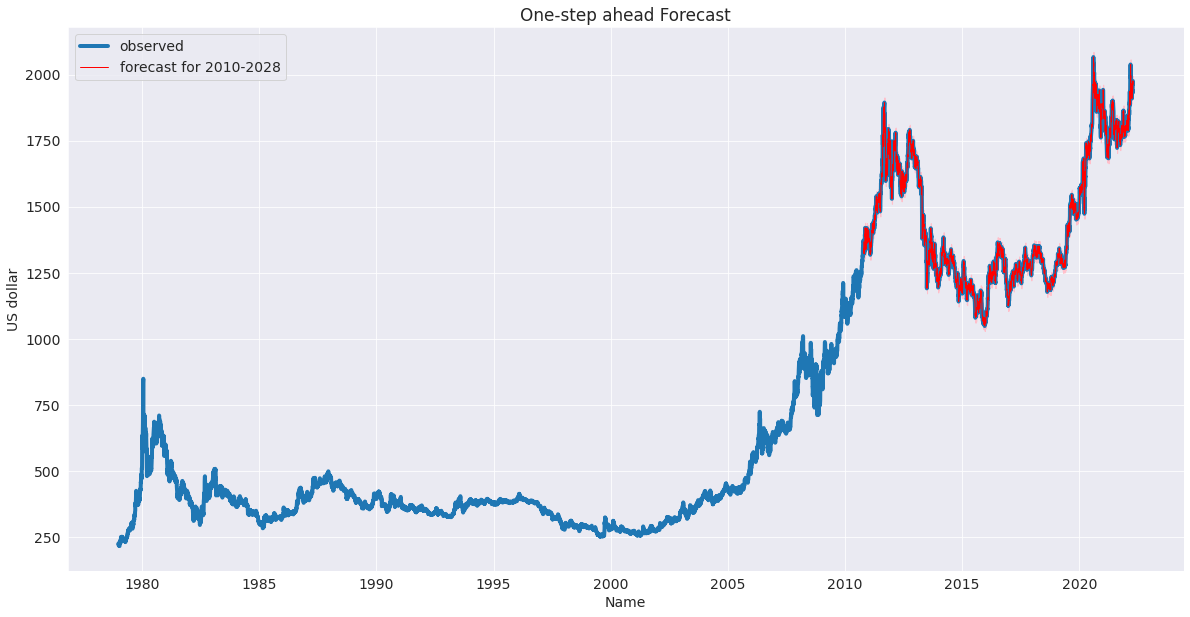

In [24]:
pred_365_traindata = results_sarima.get_prediction(start=-3000, dynamic=False)

pred_mean_365_traindata = pred_365_traindata.predicted_mean

# Get confidence intervals of forecast
confidence_intervals = pred_365_traindata.conf_int()
# print(confidence_intervals)
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower US dollar']
upper_limits = confidence_intervals.loc[:,'upper US dollar']
pred_mean_365_traindata_df = pred_mean_365_traindata.to_frame(name='forecasted_mean')
pred_mean_365_traindata_df.head()


plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y='US dollar', data=df, linewidth=4, label='observed').set_title('One-step ahead Forecast')

# Plot the mean predictions for the last 365 days of training data
sns.lineplot(x=pred_mean_365_traindata_df.index, y=pred_mean_365_traindata_df['forecasted_mean'], data=pred_mean_365_traindata_df, linewidth=1, label='forecast for 2010-2028', color='red')

# Shade the area between the confidence intervals
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

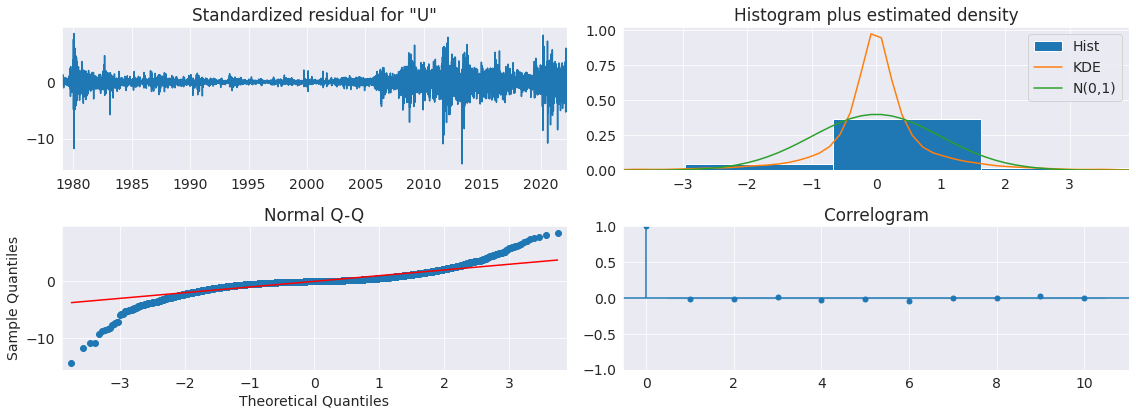

In [25]:
results_sarima.plot_diagnostics()
plt.tight_layout()
plt.show()

In [26]:
print(results_sarima.summary())

                               SARIMAX Results                                
Dep. Variable:              US dollar   No. Observations:                11296
Model:               SARIMAX(0, 2, 1)   Log Likelihood              -41753.068
Date:                Mon, 25 Apr 2022   AIC                          83512.137
Time:                        09:56:34   BIC                          83534.133
Sample:                    12-29-1978   HQIC                         83519.538
                         - 04-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.106e-05   2.67e-05      1.162      0.245   -2.13e-05    8.34e-05
ma.L1         -1.0000      0.001   -761.462      0.000      -1.003      -0.997
sigma2        95.1489      0.436    218.137      0.0

In [30]:
residuals = results_sarima.resid
mae = np.mean(np.abs(residuals))
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))

# Calculate Mean Square Error 
pred_mean_365_traindata = pred_365_traindata.predicted_mean
real_values = df[-3000:]['US dollar']
# print(pred_mean_365_traindata-real_values)
mse = ((pred_mean_365_traindata - real_values) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Absolute Error of our forecasts is 5.47
The Mean Squared Error of our forecasts is 226.46
The Root Mean Squared Error of our forecasts is 15.05


Seasonal Time Series
In the previous model, seasonality was not taken into account. Here's we'll investigate if the data is seasonal.

Non-seasonal order

p: autoregressive order

d: differencing order

q: moving average order

Seasonal order

P: seasonal autoregressive order

D: seasonal differencing order

Q: seasonal moving average order

S: number of time steps per cycle

In [40]:
results = auto_arima(df,
                    seasonal=True,
                    start_p = 1,
                    start_q = 1,
                    start_P=1,
                    start_Q=1,
                    max_P=3,
                    max_Q=3,
                    m=7, #seasonal period, freq=daily
                    information_criterion='aic',
                    trace=True,
                    error_action='ignore',
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=83496.825, Time=13.94 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=83508.776, Time=0.22 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=83509.180, Time=0.98 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=83509.114, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=83509.584, Time=0.14 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=83504.581, Time=9.24 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=83504.604, Time=8.12 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=83486.216, Time=18.41 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=83502.456, Time=11.74 sec
 ARIMA(1,1,1)(3,0,1)[7] intercept   : AIC=83476.915, Time=38.09 sec
 ARIMA(1,1,1)(3,0,0)[7] intercept   : AIC=83475.175, Time=24.82 sec
 ARIMA(0,1,1)(3,0,0)[7] intercept   : AIC=83478.988, Time=6.62 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=83479.034, Time=7.27 sec
 ARIMA(2,1,1)(3,0,0)[7] intercept   : AIC=83473.443, Time=33.87 sec
 ARIMA(2,1,1)

In [41]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                11296
Model:             SARIMAX(2, 1, 1)x(3, 0, [], 7)   Log Likelihood              -41728.721
Date:                            Mon, 25 Apr 2022   AIC                          83473.443
Time:                                    10:12:07   BIC                          83532.100
Sample:                                         0   HQIC                         83493.178
                                          - 11296                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3098      0.170      1.821      0.069      -0.024       0.643
ar.L1         -0.8394      0.049   

In [101]:
# creating a sarimax using the above quantites

sarimax_autoarima = SARIMAX(df, order=(2,1,1,) , seasonal_order=(3,0,0,7), seasonal=True, trend='c', model='mul')
auto_arima_results = sarimax_autoarima.fit() 

/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ahmad/anaconda3/envs/time_series/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69465D+00    |proj g|=  1.46494D-02


 This problem is unconstrained.



At iterate    5    f=  3.69450D+00    |proj g|=  2.87818D-04

At iterate   10    f=  3.69450D+00    |proj g|=  4.89189D-05

At iterate   15    f=  3.69450D+00    |proj g|=  4.20704D-04

At iterate   20    f=  3.69450D+00    |proj g|=  1.61129D-04

At iterate   25    f=  3.69447D+00    |proj g|=  4.43411D-03

At iterate   30    f=  3.69419D+00    |proj g|=  6.42787D-03

At iterate   35    f=  3.69412D+00    |proj g|=  1.89907D-04

At iterate   40    f=  3.69412D+00    |proj g|=  5.17514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     51      1     0     0   1.270D-05   3.694D+00
  F =   3.69411486339

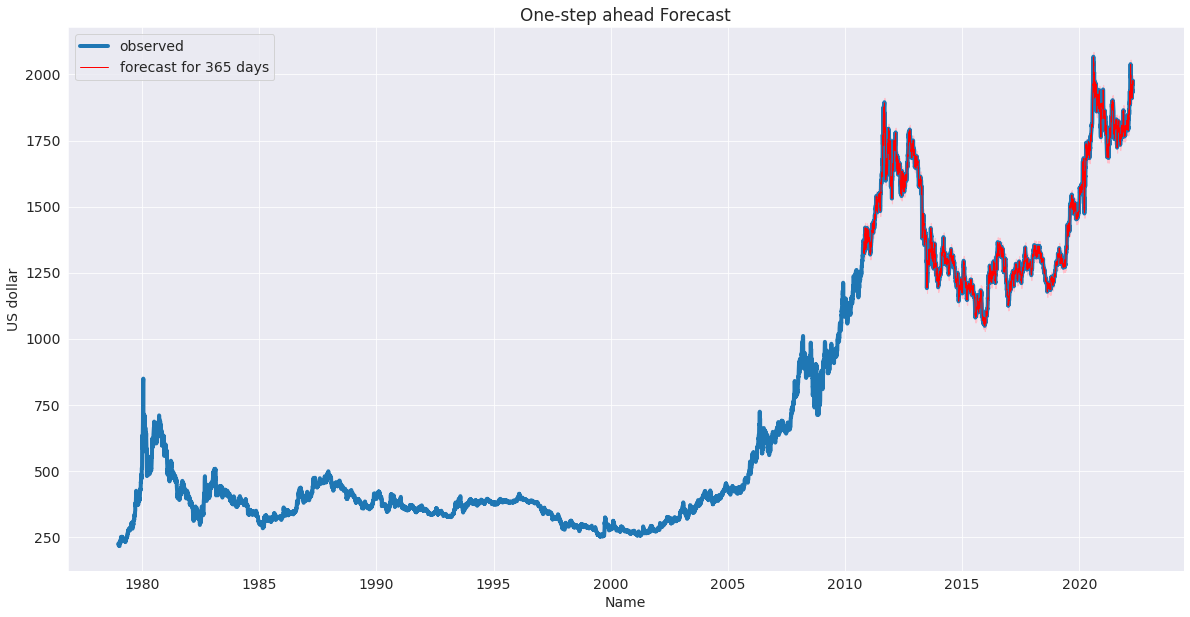

In [102]:
# dynamic=False ensures we produce one-step ahead forecasts, forecasts at each point are generated using the full history up to that point
auto_arima_pred_365_traindata = auto_arima_results.get_prediction(start=-3000, dynamic=False)

# Forecast mean 
auto_arima_pred_mean_365_traindata = auto_arima_pred_365_traindata.predicted_mean

# Get confidence intervals of forecast
auto_arima_confidence_intervals = auto_arima_pred_365_traindata.conf_int()

# Select lower and upper confidence limits
auto_arima_lower_limits = auto_arima_confidence_intervals.loc[:,'lower US dollar']
auto_arima_upper_limits = auto_arima_confidence_intervals.loc[:,'upper US dollar']

# Convert auto_arima_pred_mean_365_traindata series to a dataframe
# Inspect auto_arima_pred_mean_365_traindata_df
auto_arima_pred_mean_365_traindata_df = auto_arima_pred_mean_365_traindata.to_frame(name='forecasted_mean')

plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y='US dollar', data=df, linewidth=4, label='observed').set_title('One-step ahead Forecast')

# Plot the mean predictions
sns.lineplot(x=auto_arima_pred_mean_365_traindata_df.index, y=auto_arima_pred_mean_365_traindata_df['forecasted_mean'], data=auto_arima_pred_mean_365_traindata_df, linewidth=1, label='forecast for 365 days', color='red')

# Shade the area between the confidence intervals
plt.fill_between(auto_arima_lower_limits.index, auto_arima_lower_limits, auto_arima_upper_limits, color='pink')

In [103]:
auto_arima_pred_365_traindata = auto_arima_results.get_prediction(start=-3000, dynamic=False)
residuals = auto_arima_results.resid

# Calculate Mean Square Error for periods 2015-08-05 to 2016-12-30 (last 365 days of training data)
auto_arima_pred_mean_365_traindata = auto_arima_pred_365_traindata.predicted_mean
real_values = df[-3000:]['US dollar']
print('MAE: {}'.format(mean_absolute_error(real_values, auto_arima_pred_mean_365_traindata)))
print('MSE: {}'.format(mean_squared_error(real_values, auto_arima_pred_mean_365_traindata)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_values, auto_arima_pred_mean_365_traindata))))

MAE: 10.045330196946633
MSE: 225.4162526946712
RMSE: 15.013868678480947


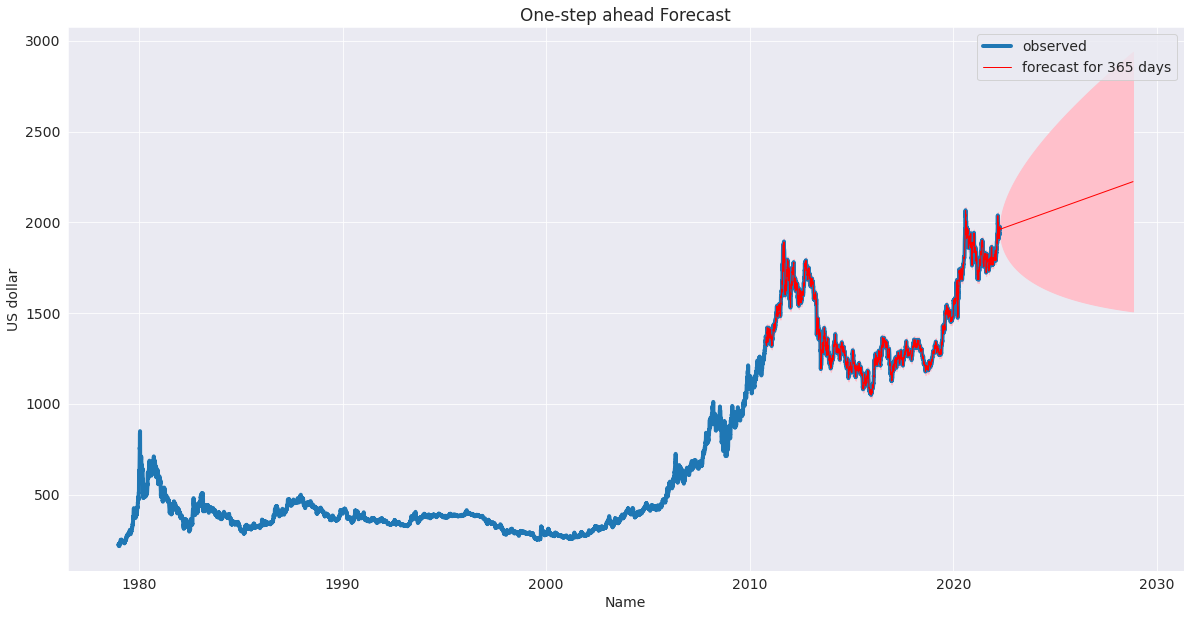

In [104]:
auto_arima_pred_365_traindata = auto_arima_results.get_prediction(start=-3000,end=13000, dynamic=False)

# Forecast mean 
auto_arima_pred_mean_365_traindata = auto_arima_pred_365_traindata.predicted_mean

# Get confidence intervals of forecast
auto_arima_confidence_intervals = auto_arima_pred_365_traindata.conf_int()

# Select lower and upper confidence limits
auto_arima_lower_limits = auto_arima_confidence_intervals.loc[:,'lower US dollar']
auto_arima_upper_limits = auto_arima_confidence_intervals.loc[:,'upper US dollar']

# Convert auto_arima_pred_mean_365_traindata series to a dataframe
# Inspect auto_arima_pred_mean_365_traindata_df
auto_arima_pred_mean_365_traindata_df = auto_arima_pred_mean_365_traindata.to_frame(name='forecasted_mean')

plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y='US dollar', data=df, linewidth=4, label='observed').set_title('One-step ahead Forecast')

# Plot the mean predictions
sns.lineplot(x=auto_arima_pred_mean_365_traindata_df.index, y=auto_arima_pred_mean_365_traindata_df['forecasted_mean'], data=auto_arima_pred_mean_365_traindata_df, linewidth=1, label='forecast for 365 days', color='red')

# Shade the area between the confidence intervals
plt.fill_between(auto_arima_lower_limits.index, auto_arima_lower_limits, auto_arima_upper_limits, color='pink')

In [105]:
auto_arima_results.save('../models/auto_arima.pckl')